# Homework 2 (draft)

## Import:

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy
import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data Configuration

In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

train_folder = './train'
test_folder = './test'

train_dataset = datasets.ImageFolder(train_folder, transform=transform)
test_dataset = datasets.ImageFolder(test_folder, transform=transform)

# dataset balancing

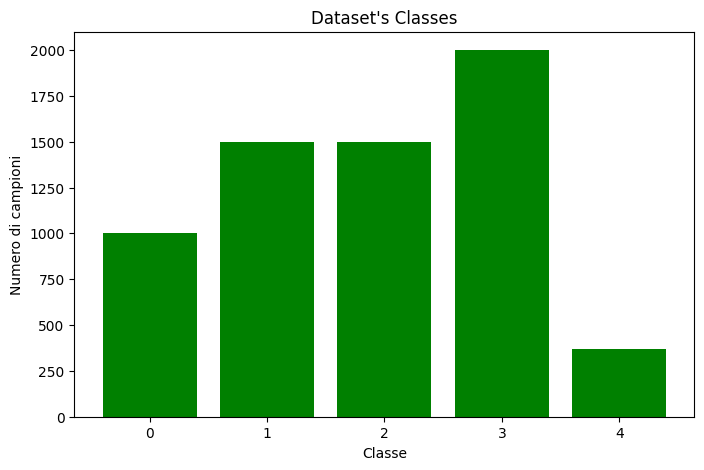

In [3]:
#plot the classes of the datasets
counts_per_class = {}

for _, label in train_dataset:
    if label in counts_per_class:
        counts_per_class[label] += 1
    else:
        counts_per_class[label] = 1

class_labels, counts = zip(*counts_per_class.items())
plt.figure(figsize=(8, 5))
plt.bar(class_labels, counts, color='green')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.title('Dataset\'s Classes')
plt.show()

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


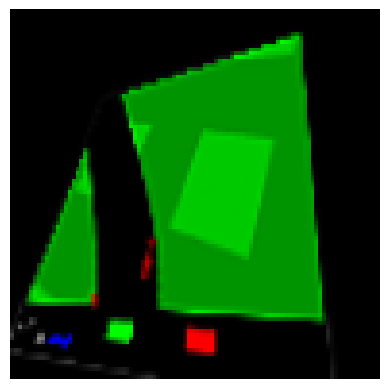

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


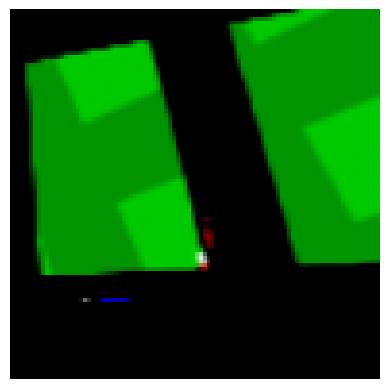

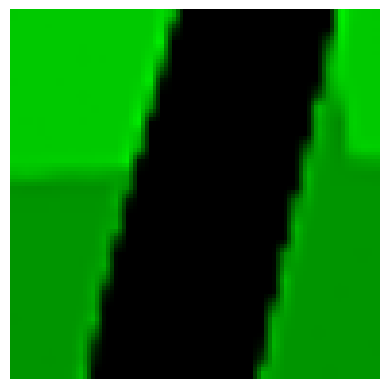

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


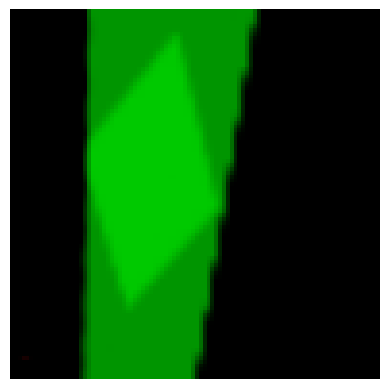

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


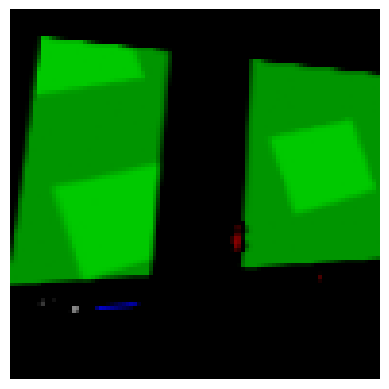

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


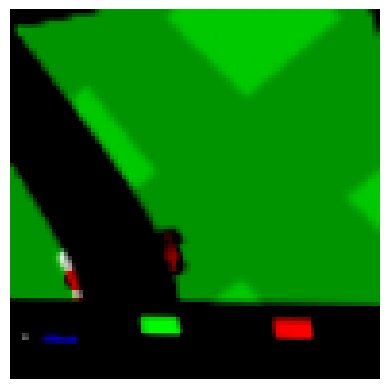

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


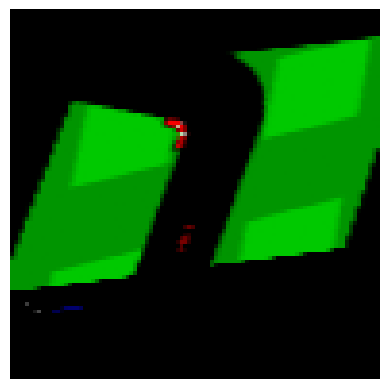

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


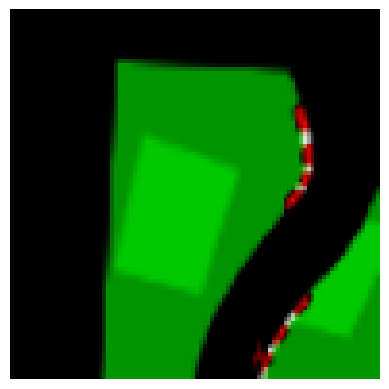

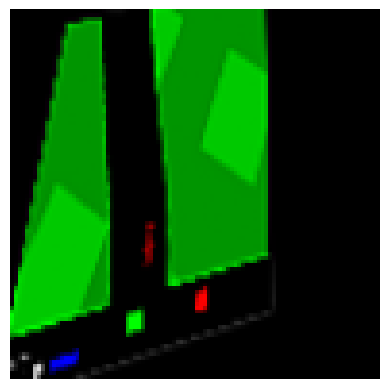

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


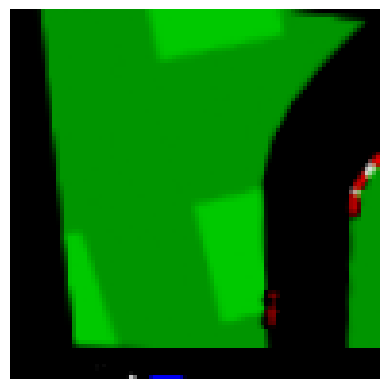

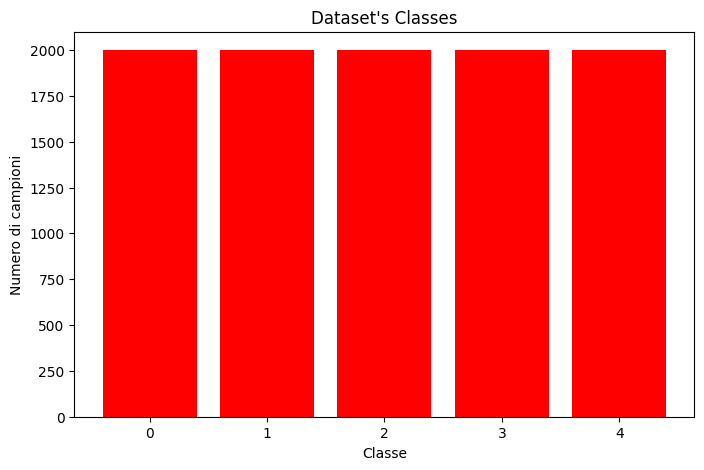

In [4]:
#data balancing 
counts_per_class = {}

for _, label in train_dataset:
    if label in counts_per_class:
        counts_per_class[label] += 1
    else:
        counts_per_class[label] = 1

#data augmentation transformation
data_augmentation_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomResizedCrop(size=(96, 96))
])

augmented_datasets = []
displayed_images = 0

for class_index in range(5): 
    target_count = max(counts_per_class[class_index], 2000) 

    additional_samples = target_count - counts_per_class[class_index]

    augmented_samples = []
    class_samples = [sample for sample in train_dataset if sample[1] == class_index]

    for _ in range(additional_samples):
        image, label = class_samples[random.randint(0, len(class_samples) - 1)]

        augmented_image = data_augmentation_transform(image)

        if displayed_images < 10:
            plt.imshow(augmented_image.permute(1, 2, 0))
            plt.axis('off')
            plt.show()
            displayed_images += 1

        augmented_samples.append((augmented_image, label))

    counts_per_class[class_index] += additional_samples

    augmented_datasets.extend(augmented_samples)

augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_datasets])

#plot graphics 
class_labels, counts = zip(*counts_per_class.items())
plt.figure(figsize=(8, 5))
plt.bar(class_labels, counts, color='red')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.title('Dataset\'s Classes')
plt.show()


In [5]:
#create the dataloader object, so the sets after the data augmentation
batch_size = 80
train_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Configuration

In [6]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(input_channels, 16, 5, padding=2)
        self.conv2 = torch.nn.Conv2d(16, 32, 5, padding=2)

        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(32)

        self.max_pool = torch.nn.MaxPool2d(2)
        
        self.fc1 = torch.nn.Linear(32*24*24, 200)
        self.fc2 = torch.nn.Linear(200, 5)

        self.drop = torch.nn.Dropout(0.2)

    def forward(self, x):
        x = torch.nn.functional.tanh(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = torch.nn.functional.tanh(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = x.reshape((-1, 32*24*24))
        x = self.drop(torch.nn.functional.tanh(self.fc1(x)))
        return self.fc2(x)

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = SimpleCNN().to(device)

2.1.2+cpu
False


In [8]:
def accuracy(net, loader, device):
  acc = Accuracy(task='multiclass',num_classes=5).to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = cnn(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [9]:
accuracy(cnn, test_loader, device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())

## Train

In [10]:
for epoch in range(20):
  
  cnn.train()
  for xb, yb in tqdm.tqdm(train_loader):
    
    xb, yb = xb.to(device), yb.to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    l = loss(ypred, yb)
    l.backward()
    opt.step()

  cnn.eval()
  print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')

100%|██████████| 125/125 [00:49<00:00,  2.54it/s]


Accuracy at epoch 0: 0.6595125794410706


100%|██████████| 125/125 [00:46<00:00,  2.69it/s]


Accuracy at epoch 1: 0.6576936841011047


100%|██████████| 125/125 [00:47<00:00,  2.64it/s]


Accuracy at epoch 2: 0.6704255938529968


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Accuracy at epoch 3: 0.599126935005188


100%|██████████| 125/125 [02:40<00:00,  1.29s/it]


Accuracy at epoch 4: 0.62786465883255


100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Accuracy at epoch 5: 0.6526009440422058


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Accuracy at epoch 6: 0.6336849927902222


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Accuracy at epoch 7: 0.6220443844795227


100%|██████████| 125/125 [00:54<00:00,  2.31it/s]


Accuracy at epoch 8: 0.6653328537940979


100%|██████████| 125/125 [00:49<00:00,  2.54it/s]


Accuracy at epoch 9: 0.610040009021759


100%|██████████| 125/125 [00:49<00:00,  2.55it/s]


Accuracy at epoch 10: 0.6915242075920105


100%|██████████| 125/125 [00:49<00:00,  2.54it/s]


Accuracy at epoch 11: 0.6515096426010132


100%|██████████| 125/125 [00:49<00:00,  2.51it/s]


Accuracy at epoch 12: 0.6562386155128479


100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Accuracy at epoch 13: 0.6591487526893616


100%|██████████| 125/125 [00:48<00:00,  2.55it/s]


Accuracy at epoch 14: 0.6507821083068848


100%|██████████| 125/125 [00:48<00:00,  2.55it/s]


Accuracy at epoch 15: 0.6500545740127563


100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Accuracy at epoch 16: 0.619134247303009


100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Accuracy at epoch 17: 0.6445980072021484


100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Accuracy at epoch 18: 0.6500545740127563


100%|██████████| 125/125 [00:52<00:00,  2.38it/s]


Accuracy at epoch 19: 0.6722444295883179


In [11]:
""" dt_cm = confusion_matrix(test_loader, cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, cmap='Greens', fmt='d', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_DT.svg', format='svg')
plt.show() """

" dt_cm = confusion_matrix(test_loader, cnn)\nplt.figure(figsize=(8, 6))\nsns.heatmap(dt_cm, annot=True, cmap='Greens', fmt='d', cbar=False)\nplt.title('Decision Tree Confusion Matrix')\nplt.xlabel('Predicted Labels')\nplt.ylabel('True Labels')\nplt.savefig('confusion_matrix_DT.svg', format='svg')\nplt.show() "

In [12]:
""" 
metric = Accuracy
# Define your hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
num_epochs = 10  # Set a reasonable number of epochs

best_accuracy = 0.0
best_hyperparameters = {}

# Random search over the hyperparameter space
for _ in range(10):  # You can adjust the number of random samples
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)

    model = cnn
    opt = torch.optim.Adam(cnn.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training loop here

    # Evaluate on the validation set
        cnn.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn(inputs)
            loss = opt(outputs, labels)
            accuracy = metric(outputs, labels)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = {'lr': lr, 'batch_size': batch_size}

print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Validation Accuracy: {best_accuracy}") """

' \nmetric = Accuracy\n# Define your hyperparameter search space\nlearning_rates = [0.001, 0.01, 0.1]\nbatch_sizes = [32, 64, 128]\nnum_epochs = 10  # Set a reasonable number of epochs\n\nbest_accuracy = 0.0\nbest_hyperparameters = {}\n\n# Random search over the hyperparameter space\nfor _ in range(10):  # You can adjust the number of random samples\n    lr = random.choice(learning_rates)\n    batch_size = random.choice(batch_sizes)\n\n    model = cnn\n    opt = torch.optim.Adam(cnn.parameters(), lr=lr)\n\n    for epoch in range(num_epochs):\n        # Training loop here\n\n    # Evaluate on the validation set\n        cnn.eval()\n    with torch.no_grad():\n        for inputs, labels in test_loader:\n            outputs = cnn(inputs)\n            loss = opt(outputs, labels)\n            accuracy = metric(outputs, labels)\n    \n    if accuracy > best_accuracy:\n        best_accuracy = accuracy\n        best_hyperparameters = {\'lr\': lr, \'batch_size\': batch_size}\n\nprint(f"Best Hype

In [13]:
""" import sys

try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model):

    seed = 2000
    obs, _ = env.reset(seed=seed)
    
    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,_,_,_,_ = env.step(action0)
    
    done = False
    while not done:
        p = model.predict(obs) # adapt to your model
        action = np.argmax(p)  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated




env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# your trained
model = cnn # your trained model

play(env, model)

 """

' import sys\n\ntry:\n    import gymnasium as gym\nexcept ModuleNotFoundError:\n    print(\'gymnasium module not found. Try to install with\')\n    print(\'pip install gymnasium[box2d]\')\n    sys.exit(1)\n\n\ndef play(env, model):\n\n    seed = 2000\n    obs, _ = env.reset(seed=seed)\n    \n    # drop initial frames\n    action0 = 0\n    for i in range(50):\n        obs,_,_,_,_ = env.step(action0)\n    \n    done = False\n    while not done:\n        p = model.predict(obs) # adapt to your model\n        action = np.argmax(p)  # adapt to your model\n        obs, _, terminated, truncated, _ = env.step(action)\n        done = terminated or truncated\n\n\n\n\nenv_arguments = {\n    \'domain_randomize\': False,\n    \'continuous\': False,\n    \'render_mode\': \'human\'\n}\n\nenv_name = \'CarRacing-v2\'\nenv = gym.make(env_name, **env_arguments)\n\nprint("Environment:", env_name)\nprint("Action space:", env.action_space)\nprint("Observation space:", env.observation_space)\n\n# your trained